In [1]:
# ============================================================
# 🧠 FinBERT + CNN for Financial Sentiment Classification
# ============================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Input
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
# ============================================================
# 1️⃣ Load FinBERT embeddings & sentiment labels
# ============================================================

embed_path = "finbert_output/finbert_embeddings.npz"
meta_path = "finbert_output/finbert_sentences.csv"

X = np.load(embed_path)["embeddings"]
sent_df = pd.read_csv(meta_path)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(sent_df["label"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Expand dims for CNN (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

✅ Train shape: (3876, 1, 768), Test shape: (970, 1, 768)


In [3]:
# ============================================================
# 2️⃣ Define CNN architecture
# ============================================================

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=256, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Conv1D(filters=128, kernel_size=1, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 classes: neg/neu/pos
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,683 (967.51 KB)

 Trainable params: 247,171 (965.51 KB)

 Non-trainable params: 512 (2.00 KB)

In [4]:
# ============================================================
# 3️⃣ Train the CNN model
# ============================================================
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8311 - loss: 0.4716 - val_accuracy: 0.8943 - val_loss: 0.2453
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8837 - loss: 0.3351 - val_accuracy: 0.9008 - val_loss: 0.2463
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8928 - loss: 0.2955 - val_accuracy: 0.9240 - val_loss: 0.2180
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9000 - loss: 0.2711 - val_accuracy: 0.9137 - val_loss: 0.2202
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8988 - loss: 0.2774 - val_accuracy: 0.9124 - val_loss: 0.2283
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8988 - loss: 0.2553 - val_accuracy: 0.9124 - val_loss: 0.2310
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9007 - loss: 0.2722 - val_accuracy: 0.9008 - val_loss: 0.2435
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9023 - loss: 0.2644 - val_accura

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📊 Model Performance:
Accuracy: 0.8979
F1 Score: 0.8986
ROC AUC (OVR): 0.9740
PR AUC (Weighted): 0.9572

📈 Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87       121
     neutral       0.94      0.89      0.92       576
    positive       0.85      0.90      0.87       273

    accuracy                           0.90       970
   macro avg       0.87      0.90      0.89       970
weighted avg       0.90      0.90      0.90       970



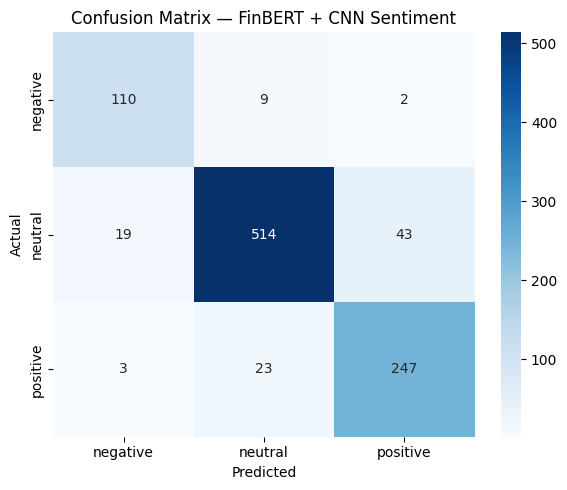

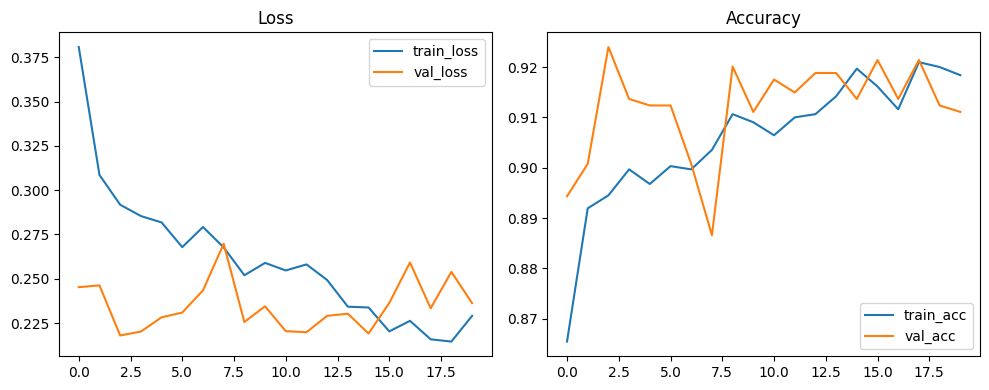


✅ Saved model → 'finbert_cnn_sentiment_full_eval.h5'
✅ Saved encoder → 'finbert_cnn_label_encoder.pkl'


In [5]:
# ============================================================
# 4️⃣ Evaluate CNN model
# ============================================================
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
roc = roc_auc_score(pd.get_dummies(y_test), y_pred_prob, multi_class="ovr")
pr = average_precision_score(pd.get_dummies(y_test), y_pred_prob, average="weighted")

print("\n📊 Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC (OVR): {roc:.4f}")
print(f"PR AUC (Weighted): {pr:.4f}")

# Classification report
target_names = [str(c) for c in le.classes_]
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix — FinBERT + CNN Sentiment")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 5️⃣ Save the model & encoder
# ============================================================
model.save("finbert_cnn_sentiment_full_eval.h5")
joblib.dump(le, "finbert_cnn_label_encoder.pkl")
print("\n✅ Saved model → 'finbert_cnn_sentiment_full_eval.h5'")
print("✅ Saved encoder → 'finbert_cnn_label_encoder.pkl'")


In [7]:
# ============================================================
# 🧠 FinBERT + CNN for Stock Movement Prediction
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, Input
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [9]:
# ============================================================
# 1️⃣ Load embeddings & stock data
# ============================================================

# Load FinBERT embeddings
embed_path = "finbert_output/finbert_embeddings.npz"
X_text = np.load(embed_path)["embeddings"]

# Load stock data (ensure alignment)
stock_df = pd.read_csv("merged_clean.csv")
stock_df = stock_df.iloc[:len(X_text)].reset_index(drop=True)

# Target variable
target_col = "movement"  # 0=Down, 1=Up
y = stock_df[target_col].values

In [11]:
# ============================================================
# 2️⃣ Prepare numeric (technical) features
# ============================================================

numeric_features = ["open", "high", "low", "close", "volume"]
num_df = stock_df[numeric_features].copy()

# Add engineered features
num_df["return"] = stock_df["close"].pct_change().fillna(0)
num_df["volatility"] = (stock_df["high"] - stock_df["low"]) / stock_df["open"]
num_df["rolling_avg"] = stock_df["close"].rolling(window=5, min_periods=1).mean()

# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(num_df)

# Combine sentiment (FinBERT) + numeric stock features
X = np.hstack([X_text, X_num])
print(f"✅ Final feature matrix shape: {X.shape}")

✅ Final feature matrix shape: (4846, 776)


In [13]:

# ============================================================
# 3️⃣ Split train/test sets
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# CNN expects a 3D input (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)


In [15]:
# ============================================================
# 4️⃣ Define CNN model
# ============================================================

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=256, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Conv1D(filters=128, kernel_size=1, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1, 256)         │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,473 (974.50 KB)

 Trainable params: 248,961 (972.50 KB)

 Non-trainable params: 512 (2.00 KB)

In [16]:
# ============================================================
# 5️⃣ Train the CNN
# ============================================================
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5237 - loss: 0.8096 - val_accuracy: 0.5477 - val_loss: 0.6893
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5206 - loss: 0.7165 - val_accuracy: 0.5399 - val_loss: 0.6956
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5167 - loss: 0.7160 - val_accuracy: 0.5013 - val_loss: 0.7155
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5303 - loss: 0.6996 - val_accuracy: 0.5168 - val_loss: 0.6953
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5394 - loss: 0.6907 - val_accuracy: 0.5438 - val_loss: 0.6949
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5587 - loss: 0.6911 - val_accuracy: 0.5322 - val_loss: 0.6862
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5739 - loss: 0.6806 - val_accuracy: 0.5554 - val_loss: 0.6843
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5660 - loss: 0.6774 - val_accuracy: 0.5322 - v

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📊 Model Performance:
Accuracy: 0.5186
F1 Score: 0.4155
ROC AUC: 0.5002
PR AUC: 0.4635

📈 Classification Report:
              precision    recall  f1-score   support

        Down       0.55      0.64      0.59       524
          Up       0.47      0.37      0.42       446

    accuracy                           0.52       970
   macro avg       0.51      0.51      0.50       970
weighted avg       0.51      0.52      0.51       970



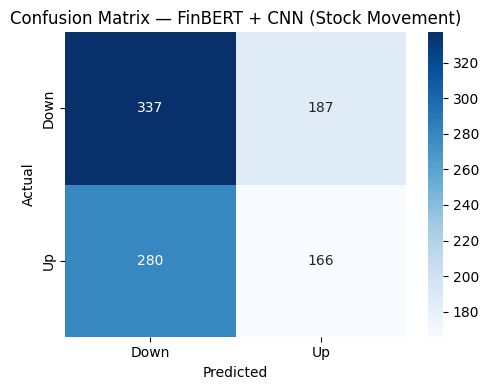

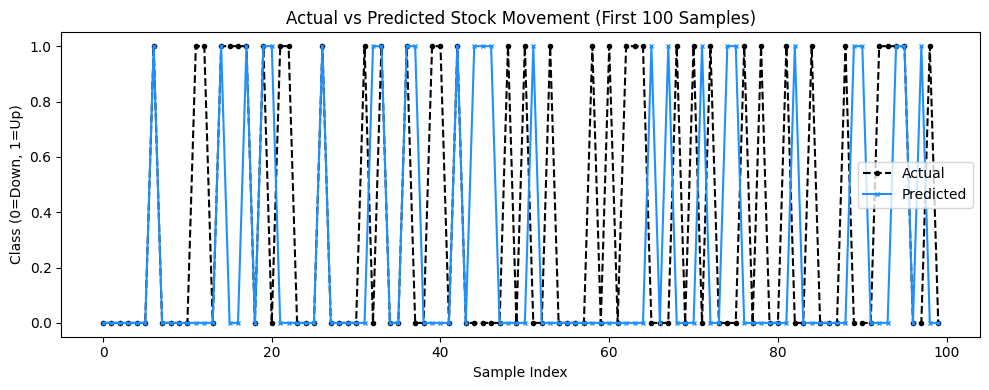

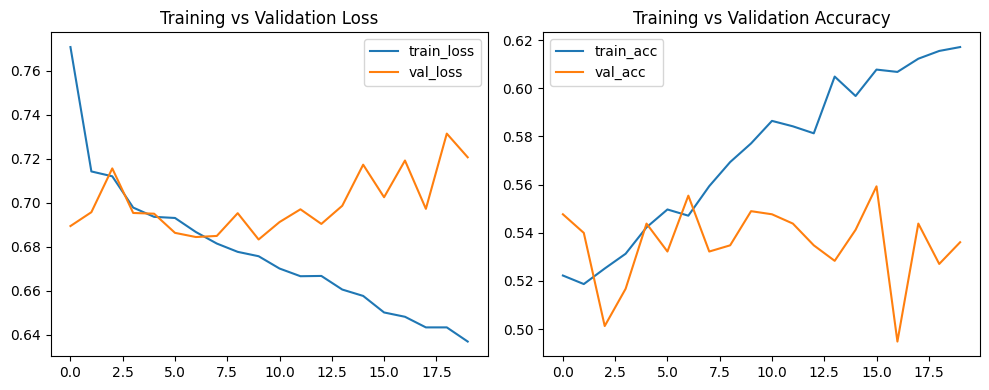


✅ Saved model → 'finbert_cnn_stock_predictor.h5'
✅ Saved scaler → 'finbert_cnn_stock_scaler.pkl'


In [17]:
# ============================================================
# 6️⃣ Evaluate the CNN model
# ============================================================
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

print("\n📊 Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# ============================================================
# 7️⃣ Visualizations & Diagnostics
# ============================================================

# Classification report
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix — FinBERT + CNN (Stock Movement)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Actual vs Predicted (First 100)
plt.figure(figsize=(10, 4))
plt.plot(y_test[:100], label="Actual", color="black", linestyle="--", marker="o", markersize=3)
plt.plot(y_pred[:100], label="Predicted", color="dodgerblue", marker="x", markersize=3)
plt.title("Actual vs Predicted Stock Movement (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class (0=Down, 1=Up)")
plt.legend()
plt.tight_layout()
plt.show()

# Training curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 8️⃣ Save model and scaler
# ============================================================
model.save("finbert_cnn_stock_predictor.h5")
joblib.dump(scaler, "finbert_cnn_stock_scaler.pkl")
print("\n✅ Saved model → 'finbert_cnn_stock_predictor.h5'")
print("✅ Saved scaler → 'finbert_cnn_stock_scaler.pkl'")